In [1]:
import os
from pathlib import Path
import re

import numpy as np
import pandas as pd
from rdkit import Chem

cwd = os.getcwd()
if cwd.endswith('notebook/PG'):
    os.chdir('../..')
    cwd = os.getcwd()

from src.pg_modelling.ligand_utils import sanitize_ligand_name, parse_plip_output, generate_conformation

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.8)
plt.rcParams['font.family'] = 'Helvetica'

palette = sns.color_palette().as_hex()

In [4]:
base_folder = Path(os.path.expanduser('~')) / 'Documents' / 'PG_modelling'
assert base_folder.is_dir()

## Load all scores

In [ ]:
E_coli_libary = base_folder / 'PG_library' / 'Escherichia_coli' / 'E_coli_cell_wall_library.xlsx'
S_equi_libary = base_folder / 'PG_library' / 'Streptococcus_equi' / 'S_equi_cell_wall_library.xlsx'
S_aureus_libary = base_folder / 'PG_library' / 'Staphylococcus_aureus' / 'S_aureus_cell_wall_library.xlsx'

pg_library = pd.concat(
    [
        pd.read_excel(
            E_coli_libary,
            sheet_name=0,
        ),
        pd.read_excel(
            E_coli_libary,
            sheet_name=1,
        ),
        pd.read_excel(
            S_equi_libary,
            sheet_name=0,
        ),
        pd.read_excel(
            S_equi_libary,
            sheet_name=1,
        ),
        pd.read_excel(
            S_aureus_libary,
            sheet_name=0,
        ),
        pd.read_excel(
            S_aureus_libary,
            sheet_name=1,
        ),
    ],
    ignore_index=True,
)
pg_library['ligand_id'] = pg_library['Name'].apply(sanitize_ligand_name)
pg_library = pg_library.drop_duplicates('ligand_id')
pg_library = pg_library.set_index('ligand_id')
print(f'N = {len(pg_library):,}')

N = 2,553


In [14]:
pg_library_subset = pg_library.rename(columns={
    'SMILES': 'smiles',
    'Monoisotopic Mass': 'mass',
})[['smiles', 'mass']]

In [16]:
# Pick larg-ish lipid from E. coli: (3S)-citryl-CoA
lipid_maps = pd.read_csv(base_folder / 'PG_library' / 'lipid_maps' / 'lipids.csv')
lipid_df = lipid_maps[lipid_maps['NAME'] == '(3S)-citryl-CoA'].copy()
lipid_df['ligand_id'] = lipid_df['NAME'].apply(lambda n: f'lipid-{sanitize_ligand_name(n)}')
lipid_df = lipid_df.set_index('ligand_id').rename(columns={
    'SMILES': 'smiles',
    'EXACT_MASS': 'mass',
})[['smiles', 'mass']]

ligands_df = pd.concat([pg_library, lipid_df])
print(f'N = {len(ligands_df):,}')

N = 2,554


In [37]:
binding_sites = {
    'Human_Lysozyme_C_P61626':  {
        ('Glu', 53),  # active site
        ('Asn', 64),
        ('Asp', 71),  # active site
        ('Asn', 78),
        ('Val', 117),
        ('Ala', 126),
        ('Trp', 127),
        ('Val', 128),
    },  # Source: https://doi.org/10.3390/app12094363
    'Lysostaphin_P10547': {
        ('Thr', 8),
        ('Asn', 9),
        ('Ile', 13),
        ('Ser', 26),
        ('Met', 41),
        ('Tyr', 60),
        ('Trp', 77),
    },  # Source: https://doi.org/10.1038/s41589-019-0393-4
    'ZoocinA_O54308': {
        ('Asn', 32),
        ('Gln', 84),
        ('Trp', 94),
        ('Asn', 96),
    },  # Source: https://doi.org/10.1016/j.bbrc.2013.09.087
}

def parse_results(protein : str, model : str):
    path = base_folder / protein / 'modelling' / model / 'scores.csv'

    df = pd.read_csv(path, index_col='ligand_name')
    df['aev_plig_pK_norm'] = df.apply(
        lambda row: row['aev_plig_pK'] / (ligands_df.loc[row.name, 'mass'] / 1000),
        axis=1,
    )
    df['binding_site'] = df['structure_file'].apply(interact_with_binding_site(protein))

    df['model'] = model

    return df.reset_index(drop=False).set_index(['model', 'protein_name', 'ligand_name', 'seed', 'sample']).sort_index()


def interact_with_binding_site(protein : str):

    def interact_with_binding_site_inner(structure_path_str : str) -> bool:
        p = (
            base_folder / protein / 'modelling' / 
            re.sub(r'^.*?modelling/', '', structure_path_str.replace('.cif', '_plip')) / 'report.xml'
        )
        if not p.is_file():
            return False
        
        plip_df = parse_plip_output(p)
        for residue_name, residue_number in plip_df[['residue_name', 'residue_number']].values:
            key = (residue_name.title(), residue_number)
            if key in binding_sites[protein]:
                return True
        return False
    
    return interact_with_binding_site_inner

In [66]:
def sort_and_drop_duplicates(df):
    out_df = df.reset_index().sort_values(
        [
            'protein_name', 'ligand_name', 'binding_site', 'posebusters_score', 'confidence', 'aev_plig_pK'
        ],
        ascending=False,
    ).drop_duplicates(
        ['protein_name', 'ligand_name']
    )

    return out_df.sort_values(
        [
            'binding_site', 'posebusters_score', 'confidence', 'aev_plig_pK'
        ],
        ascending=False
    )

In [38]:
proteins = [
    'Human_Lysozyme_C_P61626',
    'Lysostaphin_P10547',
    'ZoocinA_O54308',
]
models = [
    'af3',
    'boltz',
    'chai',
    'protenix',
]
all_scores = pd.concat([
    parse_results(protein, model)
    for protein in proteins
    for model in models
])
print(f'N = {len(all_scores):,}')
all_scores.head()

N = 900


structure_file  \
model protein_name            ligand_name seed sample                                                      
af3   Human_Lysozyme_C_P61626 G-MUR-AemA  85   0       /home/rs1521/PG/Human_Lysozyme_C_P61626/modell...   
                                               1       /home/rs1521/PG/Human_Lysozyme_C_P61626/modell...   
                                               2       /home/rs1521/PG/Human_Lysozyme_C_P61626/modell...   
                                               3       /home/rs1521/PG/Human_Lysozyme_C_P61626/modell...   
                                               4       /home/rs1521/PG/Human_Lysozyme_C_P61626/modell...   

                                                        ptm  iptm  confidence  \
model protein_name            ligand_name seed sample                           
af3   Human_Lysozyme_C_P61626 G-MUR-AemA  85   0       0.77  0.58       0.618   
                                               1       0.75  0.51       0.558   
                                               2       0.77  0.56       0.602   
                                               3       0.75  0.49       0.542   
                                               4       0.75  0.52       0.566   

                                                       posebusters_score  \
model protein_name            ligand_name seed sample                      
af3   Human_Lysozyme_C_P61626 G-MUR-AemA  85   0                    20.0   
                                               1                    19.0   
                                               2                    19.0   
                                               3                    19.0   
                                               4                    19.0   

                                                       energy_ratio  \
model protein_name            ligand_name seed sample                 
af3   Human_Lysozyme_C_P61626 G-MUR-AemA  85   0                2.3   
                                               1               25.2   
                                               2                3.8   
                                               3                3.6   
                                               4                2.6   

                                                                posebusters_errors  \
model protein_name            ligand_name seed sample                                
af3   Human_Lysozyme_C_P61626 G-MUR-AemA  85   0                               NaN   
                                               1       minimum_distance_to_protein   
                                               2       minimum_distance_to_protein   
                                               3       minimum_distance_to_protein   
                                               4       minimum_distance_to_protein   

                                                       aev_plig_pK  \
model protein_name            ligand_name seed sample                
af3   Human_Lysozyme_C_P61626 G-MUR-AemA  85   0              5.13   
                                               1              5.73   
                                               2              5.52   
                                               3              5.32   
                                               4              5.42   

                                                       aev_plig_pK_norm  \
model protein_name            ligand_name seed sample                     
af3   Human_Lysozyme_C_P61626 G-MUR-AemA  85   0                    NaN   
                                               1                    NaN   
                                               2                    NaN   
                                               3                    NaN   
                                               4                    NaN   

                                                       binding_site  
model protein_name            ligand_name se

## Evaluate accuracy

In [42]:
core_ligands = {
    'Human_Lysozyme_C_P61626': ['NAG-NAM-AqKA', 'NAG-NAM-AemA'],
    'Lysostaphin_P10547': ['KA-3-NH2-GGGGG-3br-4-qKA'],
    'ZoocinA_O54308': ['KA-3-NH2-AA-3br-4-qKA'],
}
all_core_ligands = []
for protein in proteins:
    all_core_ligands += core_ligands[protein]

In [91]:
all_scores

structure_file  \
model    protein_name               ligand_name seed sample                                                      
af3      Human_Lysozyme_C_P61626    G-MUR-AemA  85   0       /home/rs1521/PG/Human_Lysozyme_C_P61626/modell...   
                                                     1       /home/rs1521/PG/Human_Lysozyme_C_P61626/modell...   
                                                     2       /home/rs1521/PG/Human_Lysozyme_C_P61626/modell...   
                                                     3       /home/rs1521/PG/Human_Lysozyme_C_P61626/modell...   
                                                     4       /home/rs1521/PG/Human_Lysozyme_C_P61626/modell...   
...                                                                                                        ...   
protenix ZoocinA_O54308_TRD_179_283 mA-3s-4-emA 671  0       /gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...   
                                                     1       /gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...   
                                                     2       /gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...   
                                                     3       /gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...   
                                                     4       /gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...   

                                                                  ptm  \
model    protein_name               ligand_name seed sample             
af3      Human_Lysozyme_C_P61626    G-MUR-AemA  85   0       0.770000   
                                                     1       0.750000   
                                                     2       0.770000   
                                                     3       0.750000   
                                                     4       0.750000   
...                                                               ...   
protenix ZoocinA_O54308_TRD_179_283 mA-3s-4-emA 671  0       0.974652   
                                                     1       0.972671   
                                                     2       0.972122   
                                                     3       0.971608   
                                                     4       0.971674   

                                                                 iptm  \
model    protein_name               ligand_name seed sample             
af3      Human_Lysozyme_C_P61626    G-MUR-AemA  85   0       0.580000   
                                                     1       0.510000   
                                                     2       0.560000   
                                                     3       0.490000   
                                                     4       0.520000   
...                                                               ...   
protenix ZoocinA_O54308_TRD_179_283 mA-3s-4-emA 671  0       0.955033   
                                                     1       0.947545   
                                                     2       0.945041   
                                                     3       0.942349   
                                                     4       0.942025   

                                                             confidence  \
model    protein_name               ligand_name seed sample               
af3      Human_Lysozyme_C_P61626    G-MUR-AemA  85   0            0.618   
                                                     1            0.558   
                                                     2            0.602   
                                                     3            0.542   
                                                     4            0.566   
...                                                                 ...   
protenix ZoocinA_O54308_TRD_179_283 mA-3s-4-emA 671  0            0.959   
                                      

In [89]:
print('PoseBusters')
for model in models:
    df = all_scores.loc[model].reset_index()
    n = len(df[(df['posebusters_score'] == 20)])
    print(f'{model}: {n:,} of {len(df):,} ({100 * n / len(df):.1f}%)')

    for protein in proteins:
        df = all_scores.loc[model].reset_index()
        df = df[df['protein_name'].str.startswith(protein)]
        n = len(df[(df['posebusters_score'] == 20)])
        print(f'\t{protein}: {n:,} of {len(df):,} ({100 * n / len(df):.1f}%)')
    
    print()

PoseBusters
af3: 164 of 225 (72.9%)
	Human_Lysozyme_C_P61626: 30 of 75 (40.0%)
	Lysostaphin_P10547: 65 of 75 (86.7%)
	ZoocinA_O54308: 69 of 75 (92.0%)

boltz: 82 of 225 (36.4%)
	Human_Lysozyme_C_P61626: 16 of 75 (21.3%)
	Lysostaphin_P10547: 35 of 75 (46.7%)
	ZoocinA_O54308: 31 of 75 (41.3%)

chai: 130 of 225 (57.8%)
	Human_Lysozyme_C_P61626: 37 of 75 (49.3%)
	Lysostaphin_P10547: 54 of 75 (72.0%)
	ZoocinA_O54308: 39 of 75 (52.0%)

protenix: 120 of 225 (53.3%)
	Human_Lysozyme_C_P61626: 29 of 75 (38.7%)
	Lysostaphin_P10547: 57 of 75 (76.0%)
	ZoocinA_O54308: 34 of 75 (45.3%)



In [90]:
print('Binding site contact (PLIP)')
for model in models:
    df = all_scores[all_scores['posebusters_score'] == 20].loc[model].reset_index()
    df = df[df['ligand_name'].isin(all_core_ligands)]
    n = len(df[df['binding_site']])
    print(f'{model}: {n:,} of {len(df):,} ({100 * n / len(df):.1f}%)')

    for protein in proteins:
        df = all_scores.loc[model].reset_index()
        df = df[df['protein_name'].str.startswith(protein)]
        n = len(df[df['binding_site']])
        print(f'\t{protein}: {n:,} of {len(df):,} ({100 * n / len(df):.1f}%)')

    print()

Binding site contact (PLIP)
af3: 51 of 70 (72.9%)
	Human_Lysozyme_C_P61626: 74 of 75 (98.7%)
	Lysostaphin_P10547: 34 of 75 (45.3%)
	ZoocinA_O54308: 63 of 75 (84.0%)

boltz: 28 of 36 (77.8%)
	Human_Lysozyme_C_P61626: 68 of 75 (90.7%)
	Lysostaphin_P10547: 35 of 75 (46.7%)
	ZoocinA_O54308: 64 of 75 (85.3%)

chai: 48 of 57 (84.2%)
	Human_Lysozyme_C_P61626: 71 of 75 (94.7%)
	Lysostaphin_P10547: 59 of 75 (78.7%)
	ZoocinA_O54308: 68 of 75 (90.7%)

protenix: 21 of 42 (50.0%)
	Human_Lysozyme_C_P61626: 75 of 75 (100.0%)
	Lysostaphin_P10547: 8 of 75 (10.7%)
	ZoocinA_O54308: 27 of 75 (36.0%)



## Evaluate confidence predictions

How often are the core ligands first?

In [84]:
print('Confidence')
for model in models:
    n_top = 0
    for protein in proteins:
        df = all_scores[all_scores['posebusters_score'] == 20].loc[model].reset_index()
        df = df[
            (df['protein_name'].str.startswith(protein))
        ].sort_values('confidence', ascending=False).drop_duplicates(
            ['protein_name', 'ligand_name']
        )

        for ligand_name in df['ligand_name']:
            if ligand_name in core_ligands[protein]:
                n_top += 1
            else:
                break

    print(f'{model}: {n_top:,} of {len(proteins):,} ({100 * n_top / len(proteins):.1f}%)')


Confidence
af3: 2 of 3 (66.7%)
boltz: 0 of 3 (0.0%)
chai: 2 of 3 (66.7%)
protenix: 0 of 3 (0.0%)


How often do the core ligands beat the main negative control?

In [85]:
lipid_ligand_name = 'lipid-3S-citryl-CoA'

for model in models:
    n_top = 0
    for protein in proteins:
        df = all_scores[all_scores['posebusters_score'] == 20].loc[model].reset_index()
        df = df[
            (df['protein_name'].str.startswith(protein))
        ].sort_values('confidence', ascending=False).drop_duplicates(
            ['protein_name', 'ligand_name']
        )

        s1 = df[df['ligand_name'].isin(core_ligands[protein])]['confidence'].iloc[0]
        s2 = df[df['ligand_name'] == lipid_ligand_name]['confidence'].iloc[0]
        if s1 > s2:
            n_top += 1

    print(f'{model}: {n_top:,} of {len(proteins):,} ({100 * n_top / len(proteins):.1f}%)')


af3: 3 of 3 (100.0%)
boltz: 1 of 3 (33.3%)
chai: 2 of 3 (66.7%)
protenix: 2 of 3 (66.7%)


Core ligands only: how often is the accurate prediction first?

In [86]:
print('Confidence')
for model in models:
    n_top = 0
    for protein in proteins:
        df = all_scores[all_scores['posebusters_score'] == 20].loc[model].reset_index()
        df = df[
            (df['protein_name'].str.startswith(protein)) &
            df['ligand_name'].isin(core_ligands[protein])
        ].sort_values('confidence', ascending=False)

        best_row = df.iloc[0]
        if best_row['binding_site']:
            n_top += 1

    print(f'{model}: {n_top:,} of {len(proteins):,} ({100 * n_top / len(proteins):.1f}%)')


Confidence
af3: 2 of 3 (66.7%)
boltz: 3 of 3 (100.0%)
chai: 3 of 3 (100.0%)
protenix: 2 of 3 (66.7%)


## Plot PoseBusters

/var/folders/xd/714yy8tn5vz90_wtnn7vglhc0000gq/T/ipykernel_73039/1052369223.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='model', y='score', hue='protein_name', data=agg_df, ci=None)
/var/folders/xd/714yy8tn5vz90_wtnn7vglhc0000gq/T/ipykernel_73039/1052369223.py:28: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='model', y='score', data=overall_df, color='red', markers='D', scale=1.0, errwidth=0, ax=ax)
/var/folders/xd/714yy8tn5vz90_wtnn7vglhc0000gq/T/ipykernel_73039/1052369223.py:28: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  sns.pointplot(x='model', y='score', data=overall_df, color='red', markers='D', scale=1.0, errwidth=0, ax=ax)


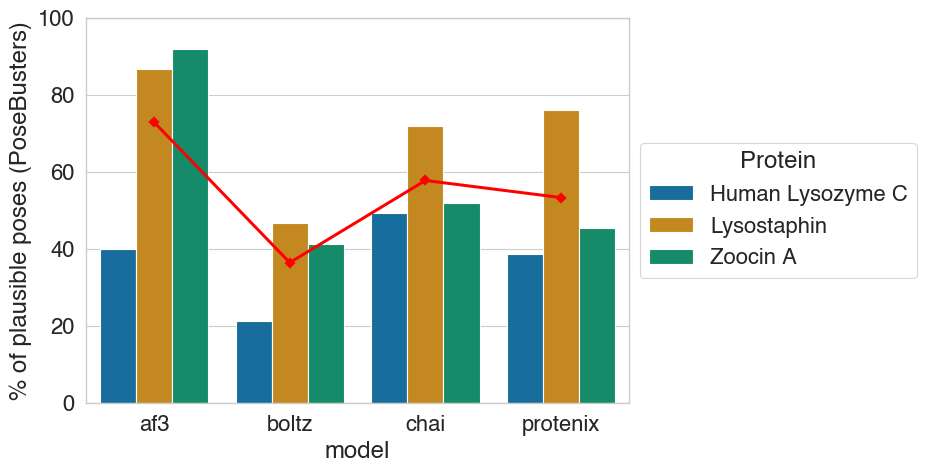

In [120]:
posebuster_df = all_scores[['posebusters_score']].copy()
posebuster_df['score'] = all_scores['posebusters_score'].apply(lambda v: 1.0 if v == 20 else 0.0)

# For aggregation purposes, reset the index so that 'model', 'protein', etc. are columns.
df_reset = posebuster_df.reset_index()
protein_name_map = {
    'Human_Lysozyme_C_P61626': 'Human Lysozyme C', 
    'Lysostaphin_P10547_SH3b_413_493': 'Lysostaphin',
    'ZoocinA_O54308_TRD_179_283': 'Zoocin A'
}
df_reset['protein_name'] = df_reset['protein_name'].apply(lambda v: protein_name_map[v])

# Compute the mean score for each model-protein pair
agg_df = df_reset.groupby(['model', 'protein_name'], as_index=False)['score'].mean()
agg_df['score'] *= 100

# Compute the overall mean score for each model
overall_df = df_reset.groupby('model', as_index=False)['score'].mean()
overall_df['score'] *= 100

# Plotting the aggregated results:
plt.figure(figsize=(7, 5))

# Create a grouped bar plot to show the aggregated score per protein within each model
ax = sns.barplot(x='model', y='score', hue='protein_name', data=agg_df, ci=None)

# Overlay the overall aggregated model score as red diamond markers.
sns.pointplot(x='model', y='score', data=overall_df, color='red', markers='D', scale=1.0, errwidth=0, ax=ax)

# Customize the plot
plt.ylabel("% of plausible poses (PoseBusters)")
plt.ylim(0, 100)
plt.legend(title='Protein', loc='center left', bbox_to_anchor=(1, 0.5))

plt.gcf().savefig('/Users/rs1521/Documents/01_Fellowship/figures/PoseBusters.pdf', dpi=300, bbox_inches='tight')

## Contact with binding site

/var/folders/xd/714yy8tn5vz90_wtnn7vglhc0000gq/T/ipykernel_73039/2913506967.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='model', y='score', hue='protein_name', data=agg_df, ci=None)
/var/folders/xd/714yy8tn5vz90_wtnn7vglhc0000gq/T/ipykernel_73039/2913506967.py:30: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(x='model', y='score', data=overall_df, color='red', markers='D', scale=1.0, errwidth=0, ax=ax)
/var/folders/xd/714yy8tn5vz90_wtnn7vglhc0000gq/T/ipykernel_73039/2913506967.py:30: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.pointplot(x='model', y='score', data=overall_df, color='red', markers='D', scale=1.0, errwidth=0, ax=ax)


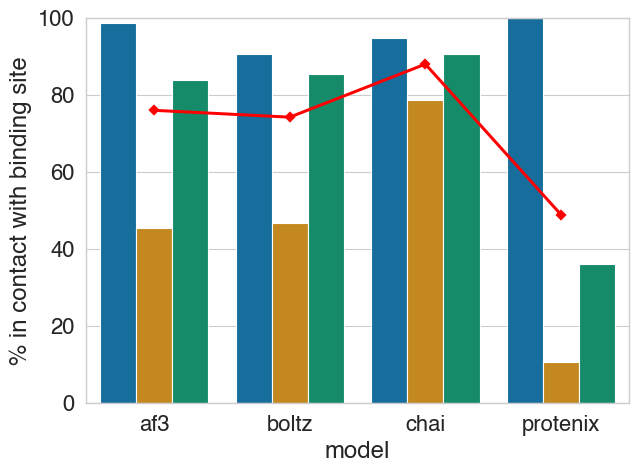

In [129]:
binding_site_df = all_scores[['binding_site']].copy()
binding_site_df['score'] = all_scores['binding_site'].apply(lambda v: 1.0 if v else 0.0)

# For aggregation purposes, reset the index so that 'model', 'protein', etc. are columns.
df_reset = binding_site_df.reset_index()
protein_name_map = {
    'Human_Lysozyme_C_P61626': 'Human Lysozyme C', 
    'Lysostaphin_P10547_SH3b_413_493': 'Lysostaphin',
    'ZoocinA_O54308_TRD_179_283': 'Zoocin A'
}
df_reset['protein_name'] = df_reset['protein_name'].apply(lambda v: protein_name_map[v])

# Compute the mean score for each model-protein pair
agg_df = df_reset.groupby(['model', 'protein_name'], as_index=False)['score'].mean()
agg_df['score'] *= 100

# Compute the overall mean score for each model
overall_df = df_reset.groupby('model', as_index=False)['score'].mean()
overall_df['score'] *= 100

# Plotting the aggregated results:
plt.figure(figsize=(7, 5))

# Create a grouped bar plot to show the aggregated score per protein within each model
ax = sns.barplot(x='model', y='score', hue='protein_name', data=agg_df, ci=None)

ax.get_legend().remove()

# Overlay the overall aggregated model score as red diamond markers.
ax = sns.pointplot(x='model', y='score', data=overall_df, color='red', markers='D', scale=1.0, errwidth=0, ax=ax)

ax.get_legend().remove()

# Customize the plot
plt.ylabel("% in contact with binding site")
plt.ylim(0, 100)

plt.gcf().savefig('/Users/rs1521/Documents/01_Fellowship/figures/binding_site.pdf', dpi=300, bbox_inches='tight')